<a href="https://colab.research.google.com/github/theslic/Homelessness-Analysis/blob/main/Homelessness_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook analyzes homelessness and what possible factors can be used to predict homelessness. We will use various different modeling methods to find out what is the best way to predcit homelessness. The data that we will use is from the U.S. Department of Housing and Urban Development (HUD) which produced a report in 2019 [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf)

## Import libraries

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Model Creation
import statsmodels.formula.api as smf
import statsmodels.api as sm


# Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso

# Model metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Tree
from sklearn import tree
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import graphviz

from sklearn.model_selection import LeaveOneOut

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [144]:
url = 'https://raw.githubusercontent.com/theslic/Homelessness-Analysis/main/clean_homeless_data.csv'
df = pd.read_csv(url, index_col=0)

## State your questions

The overall problem is to determine whether and how housing market factors are related to homelessness. To answer this general problem, you will need to ask specific questions about the data.


For our analysis we will be mainly looking at whether we can predict homelessness using various different factors. Our second goal is to determine whether it is better to use the original homeless rate or the log of the homeless rate. The reason why we are looking at the log is becuase it would be able to reduce the amount of outliers which could create a more accurate model for predicting homelessness.

## Analysis

Perform analyses necessary to answer the questions. You will likely start by trying many things, some of which are useful and some of which are not. Don't be afraid to try different analyses at first. You will edit your notebook to a clean version that retains only the essential components at the end of the project.

This file should clearly produce the graphs, tables, models, etc that appear in the communication assignment.

Here we remove the repeated columns as well as creating 2 seperate y's, one for the original rate_homeless while the other represents the log of rate_homeless. This is so that we can compare their values and determine which one is better.

In [145]:
to_remove = ['total_sheltered', 'total_unsheltered', 'total_black', 'total_latino_hispanic', 'total_asian', 'total_pacific_islander', 'total_population_0_19', 
             'total_population_65_plus', 'total_female_population', 'total_Jan_precipitation', 'total_annual_precipitation', 'rate_sheltered', 'rate_unsheltered']
df = df.drop(columns = to_remove)

In [146]:
y_orig = df['rate_homeless']
y = df['log_homeless']
X = df[df.columns.difference(['coc_number', 'rate_homeless', 'total_population', 'total_homeless', 'log_homeless'])]
X.head()

,HUD_unit_occupancy_rate,average_Jan_temperature,average_summer_temperature,city_or_urban,gini_coefficient_2016,high_housing_density,house_price_index_2009,log_median_rent,medicare_reimbursements_per_enrollee,migration_4_year_change,...,rental_vacancy_rate,share_HUD_units,share_built_before_1940,share_no_bachelors,share_overcrowded_units_2016,share_renters_2016,share_under_18_with_single_parent,share_veteran_status,suburban,utility_costs
year,,,,,,,,,,,,,,,,,,,,,
2017,99.000000,13.800000,60.799999,1,42.010002,0,11.743647,2.438863,8.751520,-0.849202,...,4.817212,3.451326,0.366995,65.634148,4.117406,39.727921,23.379078,14.535126,0,8.500000
2017,99.000000,13.800000,60.799999,0,40.675701,0,9.042710,2.249699,9.972870,-0.466562,...,7.000090,1.842005,2.236410,75.560379,9.294898,33.922234,19.786558,14.142518,0,14.607715
2017,95.083710,50.995346,80.874313,0,47.633533,0,-0.852477,1.862248,9.318163,-0.000659,...,8.249993,4.528110,7.191579,65.983711,1.235925,31.769621,32.077599,9.149558,1,19.492331
2017,87.000801,57.893360,81.939949,1,46.713249,0,-8.507004,1.858394,8.709522,0.208839,...,19.424814,4.819060,3.681716,74.543457,1.712736,32.109203,33.668129,11.647923,0,18.899839
2017,95.178665,48.382103,79.429985,0,45.165546,0,0.751167,1.362010,8.967195,0.231822,...,7.218406,4.341191,5.150007,82.332657,1.539988,27.708206,27.959316,9.135015,0,18.803186


A correlation matrix to find possible outstanding values that can be used to predict homelessness.

<Axes: >

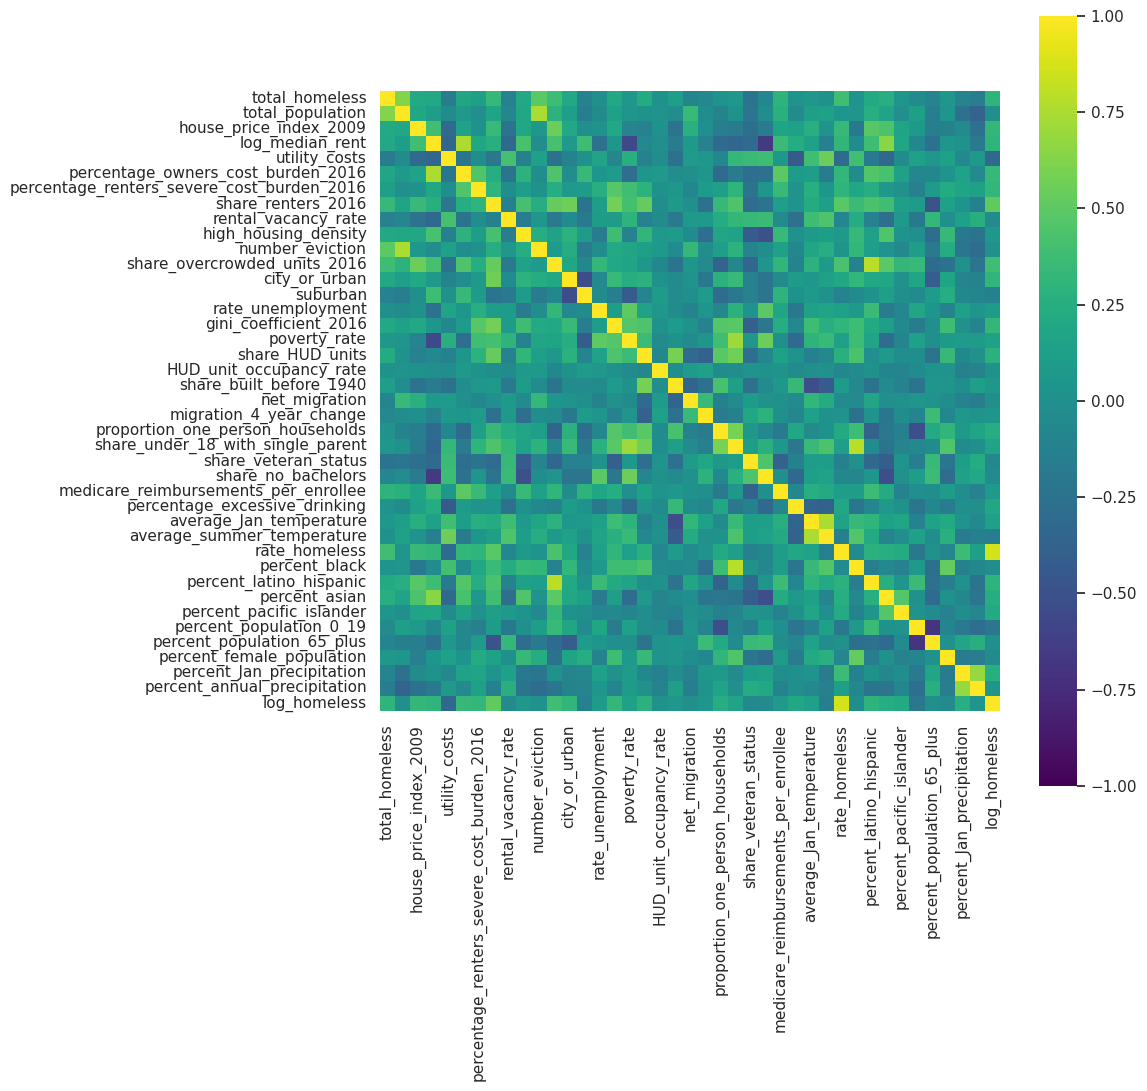

In [147]:
corr_matrix = df.drop(columns = ['coc_number']).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, cmap='viridis')

First we create a model with all the variables to view how well it does in prediction. Here we get an R-squared of .608 which is quite good meaning that using all these vaiables can be used to predict homelessness.

In [148]:
scaler = RobustScaler().fit(X)
X = pd.DataFrame(data=scaler.transform(X), columns=X.columns.values, index=X.index)
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           log_homeless   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     14.07
Date:                Fri, 26 May 2023   Prob (F-statistic):           1.35e-48
Time:                        02:16:47   Log-Likelihood:                -233.21
No. Observations:                 374   AIC:                             542.4
Df Residuals:                     336   BIC:                             691.5
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

Here we compare the accuracy of the original and the log of rate_homeless. We can see that there is not difference in the RMSE and our R-squared is a little bt different, however, from this we cannot determine which one is better at predicting homeless so we must model furthur.

In [149]:
y_pred_lr = model.predict(sm.add_constant(X))
MSE = mean_squared_error(y, y_pred_lr)
RMSE = np.sqrt(MSE)
R_squared = r2_score(y, y_pred_lr)

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 0.204  RMSE = 0.451  R-squared = 0.608


In [150]:
e_val = np.e
MSE_orig = mean_squared_error(e_val**y, e_val**y_pred_lr)
RMSE_orig = np.sqrt(MSE)
R_squared_orig = r2_score(e_val**y, e_val**y_pred_lr)

print('MSE =', MSE_orig.round(3), ' RMSE =', RMSE_orig.round(3), ' R-squared =', R_squared_orig.round(3))

MSE = 85.692  RMSE = 0.451  R-squared = 0.643


Next we draw some plots of the accuracy of the log vs the original homeless_rate which makes it easier to understand compared to a list of numbers. From this we see that the log homeless_rate is a lot more well distributed. The log homeless_rate has a more linear distrubution while the original homeless rate looks more quadratic. This means that we might want to go with the log homeless_rate for predicting homelessness.

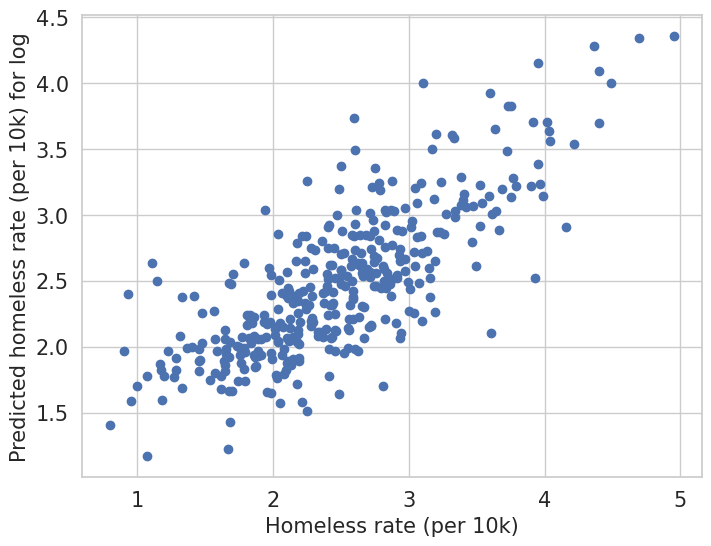

In [151]:
plt.figure(figsize = (8,6))

plt.plot(y, y_pred_lr, 'o');

plt.xlabel('Homeless rate (per 10k)', fontsize = 15)
plt.ylabel('Predicted homeless rate (per 10k) for log', fontsize = 15)

plt.tick_params(labelsize = 15)

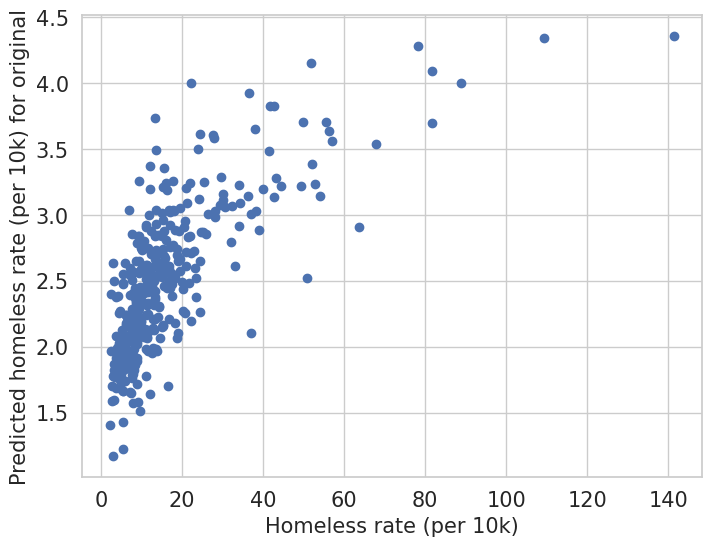

In [152]:
plt.figure(figsize = (8,6))

plt.plot(y_orig, y_pred_lr, 'o');

plt.xlabel('Homeless rate (per 10k)', fontsize = 15)
plt.ylabel('Predicted homeless rate (per 10k) for original', fontsize = 15)

plt.tick_params(labelsize = 15)

Next we want to use Lasso and Ridge regression and compare whether the original rate_homeless is better than the log. From the plot below overall with Lasso and Ridge regression we see that the log of the homeless_rate has a significantly lower RMSE and a slighly higher R-squared. However, we need a more visual representation to draw more concrete conclusions. 

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 57)

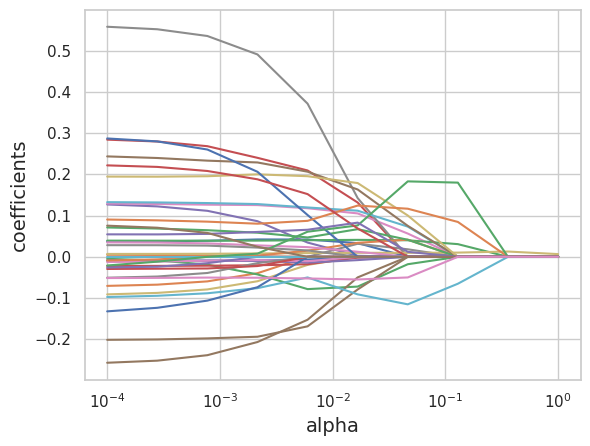

In [154]:
alphas = 10**np.linspace(-4,0,10)
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [155]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.007819996497963843

In [156]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 0.285  RMSE = 0.534  R-squared = 0.453


In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y_orig, test_size=.2, random_state = 57)

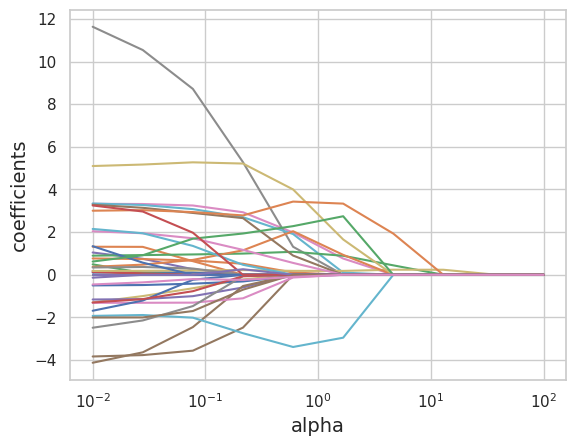

In [158]:
alphas = 10**np.linspace(-2,2,10)
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [159]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.3493627713475049

In [160]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 178.834  RMSE = 13.373  R-squared = 0.417


In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 57)

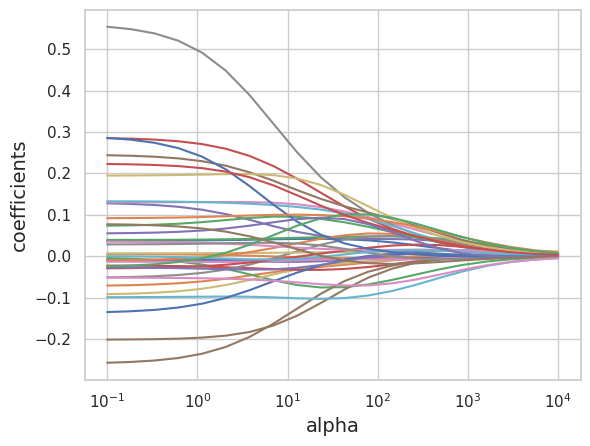

In [162]:
alphas_r = 10**np.linspace(-1,4,20)
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas_r:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas_r, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [163]:
ridgecv = RidgeCV(alphas = alphas_r, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(X_train, y_train);
ridgecv.alpha_

42.81332398719391

In [164]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(X_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(X_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 0.286  RMSE = 0.535  R-squared = 0.451


In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y_orig, test_size=.2, random_state = 57)

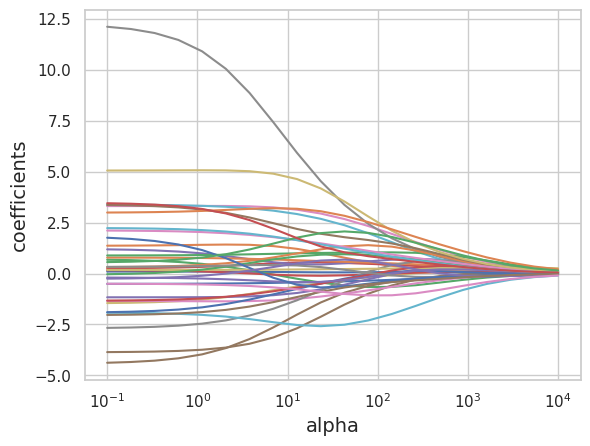

In [166]:
alphas_r = 10**np.linspace(-1,4,20)
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas_r:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas_r, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [167]:
ridgecv = RidgeCV(alphas = alphas_r, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(X_train, y_train);
ridgecv.alpha_

23.357214690901213

In [168]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(X_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(X_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 179.322  RMSE = 13.391  R-squared = 0.415


Next we move on to the XGB regressor which was known to be one of the most effective methods in predicting values. When we compare the difference between the homeless_rate and the log we see the the log has a much more spread out distribution, but it still follows a slight linear line. On the otherhand we see that the original homeless_rate has a lot of values concentrated at the bottom left, however it seem that the log method is better at getting accurate predictions compared to the original homeless-rate.

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 57)

In [170]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa78969a020>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa789699ea0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa78969ab30>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa78969ba90>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [171]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8473749394652338, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2114870938191653, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09706197439992509, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=133, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [172]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8473749394652338, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2114870938191653, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09706197439992509, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=133, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [173]:
y_pred_xgb = model_xgb.predict(X_test)

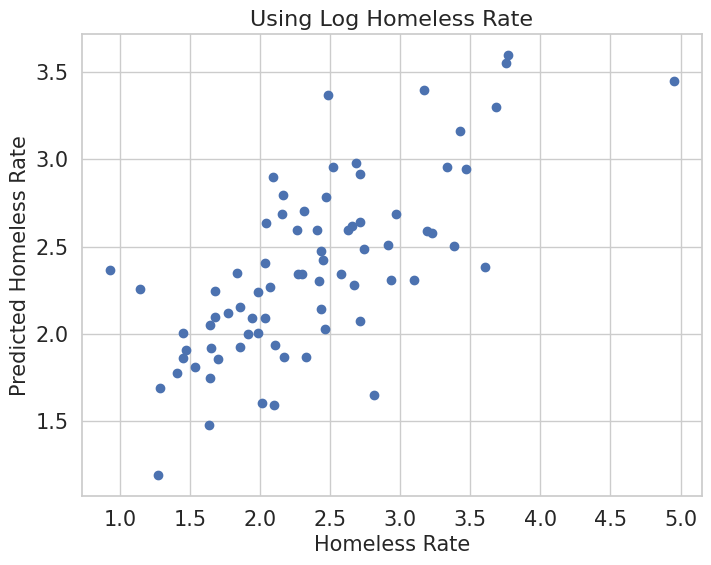

In [174]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('Homeless Rate', fontsize = 15)
plt.ylabel('Predicted Homeless Rate', fontsize = 15)
plt.title("Using Log Homeless Rate", fontsize = 16)

plt.tick_params(labelsize = 15)

In [175]:
mean_squared_error(y_test, y_pred_xgb, squared = False).round(3)

0.51

In [176]:
mean_absolute_error(y_test, y_pred_xgb).round(3)

0.399

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y_orig, test_size=.2, random_state = 57)

In [178]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa789511ae0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa789511030>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa7895113c0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa7895105e0>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [179]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8290237384264085, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3525450047710178, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04265862594890703, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=135, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [180]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8290237384264085, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3525450047710178, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04265862594890703, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=135, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [181]:
y_pred_xgb = model_xgb.predict(X_test)

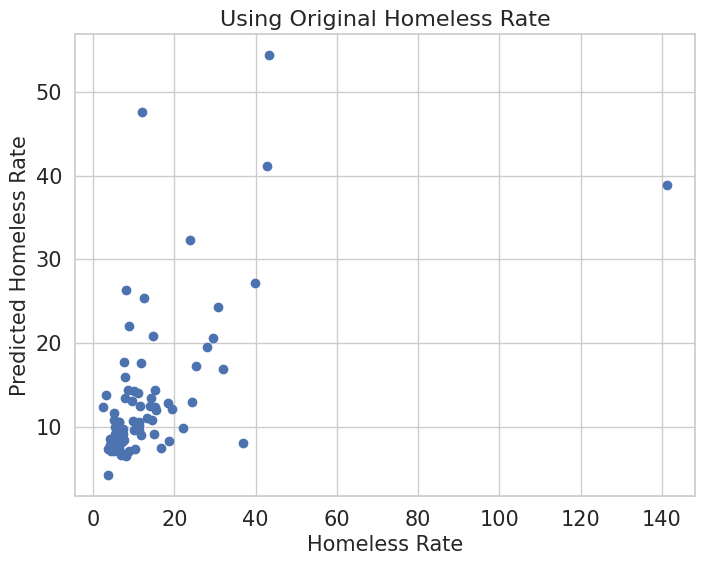

In [182]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('Homeless Rate', fontsize = 15)
plt.ylabel('Predicted Homeless Rate', fontsize = 15)
plt.title("Using Original Homeless Rate", fontsize = 16)

plt.tick_params(labelsize = 15)

In [183]:
mean_squared_error(y_test, y_pred_xgb, squared = False).round(3)

14.417

In [184]:
mean_absolute_error(y_test, y_pred_xgb).round(3)

7.03

Our final method is a decision tree to see whether it is better to use the homeless_rate or its log. We find the best tree depth and use it with k-folds to find and plot the distribution of RMSE values at different k-folds. From this we see that when we use the original rate of homeless we have a varied distribution with a RMSE as high as ~31 and as low as 5. However, when we look at the log section we have a max RMSE of 0.8 and a minimum of 0.5 which is significantly smaller than the original rate. This might suggest that the log is better to use when predicting homelessness.

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y_orig, test_size=.2, random_state = 57)

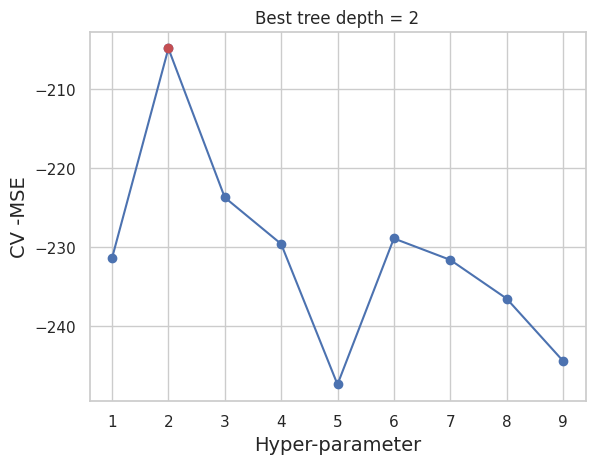

In [186]:
model = tree.DecisionTreeRegressor()

# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

# Do the cross validation
modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

# Get the scores
scores = modelCV.cv_results_["mean_test_score"]

# Get the best value of alpha
best_tree = modelCV.best_params_['max_depth']

# Plot
plt.plot(parms, scores,'o-')
plt.plot(best_tree, scores[parms == best_tree],'ro')

plt.xlabel('Hyper-parameter', fontsize = 14)
plt.ylabel('CV -MSE', fontsize = 14)
plt.title('Best tree depth = ' + str(best_tree));

In [187]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

# Initialize a list to record the RMSE
tree_rmse = []

# Create the model object
model = tree.DecisionTreeRegressor()

# Create the leave one out object
loo = LeaveOneOut()

# Loop over all splits
for train_index, test_index in loo.split(X):

    X_train = X.iloc[train_index,:]
    y_train = y_orig.iloc[train_index]

    X_test = X.iloc[test_index,:]
    y_test = y_orig.iloc[test_index]

    # Do the cross validation
    modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

    # Get the scores
    scores = modelCV.cv_results_["mean_test_score"]

    # Get the best value of alpha
    best_tree = modelCV.best_params_['max_depth']

    # Fit the model
    tree_model = tree.DecisionTreeRegressor(max_depth=best_tree)

    tree_model.fit(X_train, y_train)

    # Predict the left out value
    y_prediction = tree_model.predict(X_test)

    # Record the RMSE
    tree_rmse.append(mean_squared_error(y_test, y_prediction, squared=False))

In [188]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

In [189]:
# Initialize a list to record the RMSE
tree_rmse_kfold = []

# Create the model object
model = tree.DecisionTreeRegressor()

# Create the k-folds object with the number of splits
kf = KFold(n_splits=10)

# Loop over all splits
for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index,:]
    y_train = y_orig.iloc[train_index]

    X_test = X.iloc[test_index,:]
    y_test = y_orig.iloc[test_index]

    # Do the cross validation
    modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

    # Get the scores
    scores = modelCV.cv_results_["mean_test_score"]

    # Get the best value of alpha
    best_tree = modelCV.best_params_['max_depth']

    # Fit the best model
    tree_model = tree.DecisionTreeRegressor(max_depth=best_tree)

    tree_model.fit(X_train, y_train)

    # Predict
    y_prediction = tree_model.predict(X_test)

    tree_rmse_kfold.append(mean_squared_error(y_test, y_prediction, squared=False))

Text(0.5, 1.0, 'Original Rate Homeless')

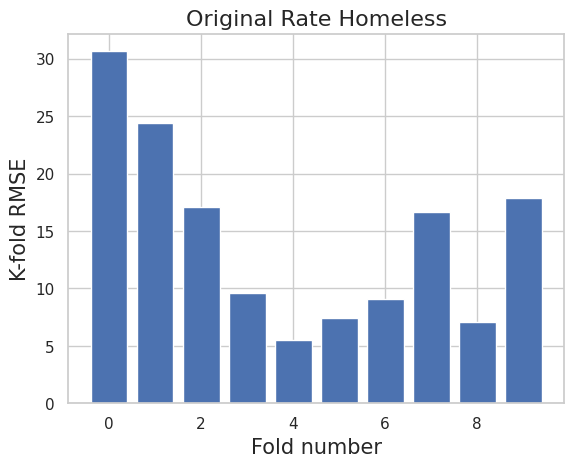

In [190]:
plt.bar(np.arange(kf.get_n_splits()), tree_rmse_kfold);
plt.xlabel('Fold number', fontsize=15);
plt.ylabel('K-fold RMSE', fontsize=15);
plt.title('Original Rate Homeless', fontsize=16)

In [191]:
pd.DataFrame(tree_rmse_kfold).describe()

,0
count,10.000000
mean,14.541376
std,8.307437
min,5.464538
25%,7.857939
50%,13.140291
75%,17.702386
max,30.651259


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 57)

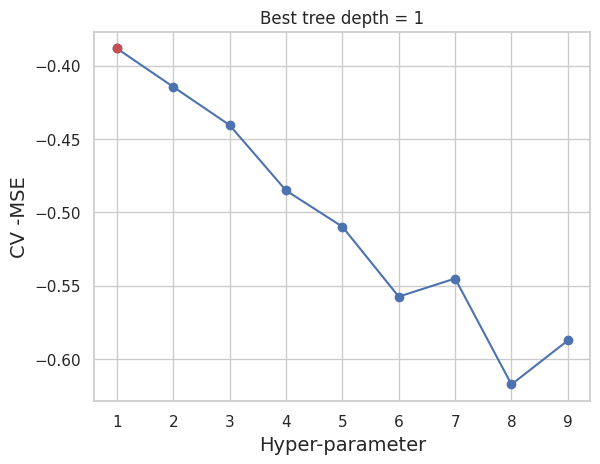

In [193]:
model = tree.DecisionTreeRegressor()

# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

# Do the cross validation
modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

# Get the scores
scores = modelCV.cv_results_["mean_test_score"]

# Get the best value of alpha
best_tree = modelCV.best_params_['max_depth']

# Plot
plt.plot(parms, scores,'o-')
plt.plot(best_tree, scores[parms == best_tree],'ro')

plt.xlabel('Hyper-parameter', fontsize = 14)
plt.ylabel('CV -MSE', fontsize = 14)
plt.title('Best tree depth = ' + str(best_tree));

In [194]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

# Initialize a list to record the RMSE
tree_rmse = []

# Create the model object
model = tree.DecisionTreeRegressor()

# Create the leave one out object
loo = LeaveOneOut()

# Loop over all splits
for train_index, test_index in loo.split(X):

    X_train = X.iloc[train_index,:]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index,:]
    y_test = y.iloc[test_index]

    # Do the cross validation
    modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

    # Get the scores
    scores = modelCV.cv_results_["mean_test_score"]

    # Get the best value of alpha
    best_tree = modelCV.best_params_['max_depth']

    # Fit the model
    tree_model = tree.DecisionTreeRegressor(max_depth=best_tree)

    tree_model.fit(X_train, y_train)

    # Predict the left out value
    y_prediction = tree_model.predict(X_test)

    # Record the RMSE
    tree_rmse.append(mean_squared_error(y_test, y_prediction, squared=False))

In [195]:
# Values of tree depth to test
parms = np.arange(1,10)
# Define the set of parameters to tune (just tree depth)
tuned_parameters = [{"max_depth": parms}]
# Specify the number of folds
n_folds = 5

In [196]:
# Initialize a list to record the RMSE
tree_rmse_kfold = []

# Create the model object
model = tree.DecisionTreeRegressor()

# Create the k-folds object with the number of splits
kf = KFold(n_splits=10)

# Loop over all splits
for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index,:]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index,:]
    y_test = y.iloc[test_index]

    # Do the cross validation
    modelCV = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False, scoring = 'neg_mean_squared_error').fit(X_train, y_train)

    # Get the scores
    scores = modelCV.cv_results_["mean_test_score"]

    # Get the best value of alpha
    best_tree = modelCV.best_params_['max_depth']

    # Fit the best model
    tree_model = tree.DecisionTreeRegressor(max_depth=best_tree)

    tree_model.fit(X_train, y_train)

    # Predict
    y_prediction = tree_model.predict(X_test)

    tree_rmse_kfold.append(mean_squared_error(y_test, y_prediction, squared=False))

Text(0.5, 1.0, 'Log Rate Homeless')

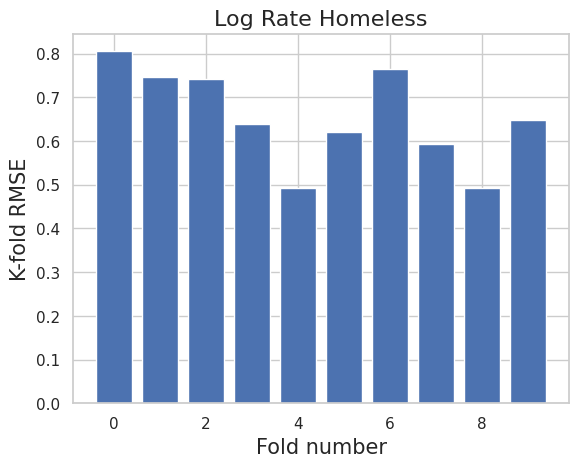

In [199]:
plt.bar(np.arange(kf.get_n_splits()), tree_rmse_kfold);
plt.xlabel('Fold number', fontsize=15);
plt.ylabel('K-fold RMSE', fontsize=15);
plt.title('Log Rate Homeless', fontsize=16)

In [198]:
pd.DataFrame(tree_rmse_kfold).describe()

,0
count,10.000000
mean,0.654271
std,0.110224
min,0.491627
25%,0.599669
50%,0.643562
75%,0.745665
max,0.805310


## Conclusion

From the different methods we used to see if we should use the rate_homeless or the log of it we saw various results. For the normal modeling we saw that the distribution for the log homeless rate was a lot more linear. We saw similar results with the Lasso and Ridge regression where we saw that the RMSE values for the log homeless rate was significantly lower than the original homeless rate. In our XGB regression section we also see that the log homeless rate seems to have better results. However, when we use the decision tree we see that our distribution of RMSE values are a lot smaller when we use the log homeless rate. There was only a 0.3 difference between the max and min of the RMSE. This signifies that while it seems to predict the homelessness better it is becuase the values are so small therefore making it seem a lot better than it actually it. Therefore while the RMSE value do show that maybe using the log of the homeless rate is better than the homeless rate there are other factors one should consider before using the log of the homeless rate. It would be better to use the original homeless rate even though it has a high RMSE value because it is a lot more controlled and gives a lot more accurate and usable prediction compared to the log of the homeless rate.